## Nested Grid Problem

This example shows how the MODFLOW 6 DISV Package can be used to simulate
a nested grid problem.  The example corresponds to the first example
described in the MODFLOW-USG documentation.  The problem is run without and
with the XT3D option of the NPF Package to improve the solution.


### Initial setup

Import dependencies, define the example name and workspace, and read settings from environment variables.

In [1]:
import os
import pathlib as pl

import flopy
import flopy.utils.cvfdutil
import git
import matplotlib.pyplot as plt
import numpy as np
from flopy.plot.styles import styles
from modflow_devtools.misc import get_env, timed

# Example name and workspace paths. If this example is running
# in the git repository, use the folder structure described in
# the README. Otherwise just use the current working directory.
try:
    root = pl.Path(git.Repo(".", search_parent_directories=True).working_dir)
except:
    root = None
workspace = root / "examples" if root else pl.Path.cwd()
figs_path = root / "figures" if root else pl.Path.cwd()

# Settings from environment variables
write = get_env("WRITE", True)
run = get_env("RUN", True)
plot = get_env("PLOT", True)
plot_show = get_env("PLOT_SHOW", True)
plot_save = get_env("PLOT_SAVE", True)

### Define parameters

Define model units, parameters and other settings.

In [2]:
# Model units
length_units = "meters"
time_units = "days"

# Scenario-specific parameters
parameters = {
    "ex-gwf-u1disv": {
        "xt3d": False,
    },
    "ex-gwf-u1disv-x": {
        "xt3d": True,
    },
}

# Model parameters
nper = 1  # Number of periods
nlay = 1  # Number of layers
top = 0.0  # Top of the model ($m$)
botm = -100.0  # Layer bottom elevations ($m$)
strt = 0.0  # Starting head ($m$)
icelltype = 0  # Cell conversion type
k11 = 1.0  # Horizontal hydraulic conductivity ($m/d$)

# Static temporal data used by TDIS file
# Simulation has 1 steady stress period (1 day)
# and 3 transient stress periods (10 days each).
# Each transient stress period has 120 2-hour time steps.
perlen = [1.0]
nstp = [1]
tsmult = [1.0, 1.0, 1.0]
tdis_ds = list(zip(perlen, nstp, tsmult))

# create the disv grid
# outer grid
nlay = 1
nrow = ncol = 7
delr = 100.0 * np.ones(ncol)
delc = 100.0 * np.ones(nrow)
tp = np.zeros((nrow, ncol))
bt = -100.0 * np.ones((nlay, nrow, ncol))
idomain = np.ones((nlay, nrow, ncol))
idomain[:, 2:5, 2:5] = 0
sg1 = flopy.discretization.StructuredGrid(
    delr=delr, delc=delc, top=tp, botm=bt, idomain=idomain
)
# inner grid
nlay = 1
nrow = ncol = 9
delr = 100.0 / 3.0 * np.ones(ncol)
delc = 100.0 / 3.0 * np.ones(nrow)
tp = np.zeros((nrow, ncol))
bt = -100 * np.ones((nlay, nrow, ncol))
idomain = np.ones((nlay, nrow, ncol))
sg2 = flopy.discretization.StructuredGrid(
    delr=delr,
    delc=delc,
    top=tp,
    botm=bt,
    xoff=200.0,
    yoff=200,
    idomain=idomain,
)

# get the disv grid arguments
gridprops = flopy.utils.cvfdutil.gridlist_to_disv_gridprops([sg1, sg2])

# Solver parameters
nouter = 50
ninner = 100
hclose = 1e-9
rclose = 1e-6

/opt/hostedtoolcache/Python/3.9.21/x64/lib/python3.9/site-packages/flopy/utils/cvfdutil.py:408: PendingDeprecationWarning: the gridlist_to_disv_gridprops function is deprecated and will be removed in version 3.9. Use flopy.utils.cvfdutil.Lgr() instead, which allows a nested grid to be created and exported to a DISV mesh.
  warnings.warn(


### Model setup

Define functions to build models, write input files, and run the simulation.

In [3]:
def build_models(sim_name, xt3d):
    sim_ws = os.path.join(workspace, sim_name)
    sim = flopy.mf6.MFSimulation(sim_name=sim_name, sim_ws=sim_ws, exe_name="mf6")
    flopy.mf6.ModflowTdis(sim, nper=nper, perioddata=tdis_ds, time_units=time_units)
    flopy.mf6.ModflowIms(
        sim,
        linear_acceleration="bicgstab",
        outer_maximum=nouter,
        outer_dvclose=hclose,
        inner_maximum=ninner,
        inner_dvclose=hclose,
        rcloserecord=f"{rclose} strict",
    )
    gwf = flopy.mf6.ModflowGwf(sim, modelname=sim_name, save_flows=True)
    flopy.mf6.ModflowGwfdisv(
        gwf,
        length_units=length_units,
        nlay=nlay,
        top=top,
        botm=botm,
        **gridprops,
    )
    flopy.mf6.ModflowGwfnpf(
        gwf,
        icelltype=icelltype,
        k=k11,
        save_specific_discharge=True,
        xt3doptions=xt3d,
    )
    flopy.mf6.ModflowGwfic(gwf, strt=strt)

    chd_spd = []
    chd_spd += [[0, i, 1.0] for i in [0, 7, 14, 18, 22, 26, 33]]
    chd_spd = {0: chd_spd}
    flopy.mf6.ModflowGwfchd(
        gwf,
        stress_period_data=chd_spd,
        pname="CHD-LEFT",
        filename=f"{sim_name}.left.chd",
    )

    chd_spd = []
    chd_spd += [[0, i, 0.0] for i in [6, 13, 17, 21, 25, 32, 39]]
    chd_spd = {0: chd_spd}
    flopy.mf6.ModflowGwfchd(
        gwf,
        stress_period_data=chd_spd,
        pname="CHD-RIGHT",
        filename=f"{sim_name}.right.chd",
    )

    head_filerecord = f"{sim_name}.hds"
    budget_filerecord = f"{sim_name}.cbc"
    flopy.mf6.ModflowGwfoc(
        gwf,
        head_filerecord=head_filerecord,
        budget_filerecord=budget_filerecord,
        saverecord=[("HEAD", "ALL"), ("BUDGET", "ALL")],
    )

    return sim


def write_models(sim, silent=True):
    sim.write_simulation(silent=silent)


@timed
def run_models(sim, silent=False):
    success, buff = sim.run_simulation(silent=silent, report=True)
    assert success, buff


# ### Plotting results
#
# Define functions to plot model results.

In [4]:
# Figure properties
figure_size = (6, 6)


def plot_grid(idx, sim):
    with styles.USGSMap():
        sim_name = list(parameters.keys())[idx]
        sim_ws = os.path.join(workspace, sim_name)
        gwf = sim.get_model(sim_name)

        fig = plt.figure(figsize=figure_size)
        fig.tight_layout()

        ax = fig.add_subplot(1, 1, 1, aspect="equal")
        pmv = flopy.plot.PlotMapView(model=gwf, ax=ax, layer=0)
        pmv.plot_grid()
        pmv.plot_bc(name="CHD-LEFT", alpha=0.75)
        pmv.plot_bc(name="CHD-RIGHT", alpha=0.75)
        ax.set_xlabel("x position (m)")
        ax.set_ylabel("y position (m)")
        for i, (x, y) in enumerate(
            zip(gwf.modelgrid.xcellcenters, gwf.modelgrid.ycellcenters)
        ):
            ax.text(
                x,
                y,
                f"{i + 1}",
                fontsize=6,
                horizontalalignment="center",
                verticalalignment="center",
            )
        v = gwf.disv.vertices.array
        ax.plot(v["xv"], v["yv"], "yo")
        for i in range(v.shape[0]):
            x, y = v["xv"][i], v["yv"][i]
            ax.text(
                x,
                y,
                f"{i + 1}",
                fontsize=5,
                color="red",
                horizontalalignment="center",
                verticalalignment="center",
            )

        if plot_show:
            plt.show()
        if plot_save:
            fpth = figs_path / f"{sim_name}-grid.png"
            fig.savefig(fpth)


def plot_head(idx, sim):
    with styles.USGSMap():
        sim_name = list(parameters.keys())[idx]
        sim_ws = os.path.join(workspace, sim_name)
        gwf = sim.get_model(sim_name)

        fig = plt.figure(figsize=(7.5, 5))
        fig.tight_layout()

        head = gwf.output.head().get_data()[:, 0, :]

        # create MODFLOW 6 cell-by-cell budget object
        qx, qy, qz = flopy.utils.postprocessing.get_specific_discharge(
            gwf.output.budget().get_data(text="DATA-SPDIS", totim=1.0)[0], gwf
        )

        ax = fig.add_subplot(1, 2, 1, aspect="equal")
        pmv = flopy.plot.PlotMapView(model=gwf, ax=ax, layer=0)
        pmv.plot_grid()
        cb = pmv.plot_array(head, cmap="jet")
        pmv.plot_vector(qx, qy, normalize=False, color="0.75")
        cbar = plt.colorbar(cb, shrink=0.25)
        cbar.ax.set_xlabel(r"Head, ($m$)")
        ax.set_xlabel("x position (m)")
        ax.set_ylabel("y position (m)")
        styles.heading(ax, letter="A", heading="Simulated Head")

        ax = fig.add_subplot(1, 2, 2, aspect="equal")
        pmv = flopy.plot.PlotMapView(model=gwf, ax=ax, layer=0)
        pmv.plot_grid()
        x = np.array(gwf.modelgrid.xcellcenters) - 50.0
        slp = (1.0 - 0.0) / (50.0 - 650.0)
        heada = slp * x + 1.0
        cb = pmv.plot_array(head - heada, cmap="jet")
        cbar = plt.colorbar(cb, shrink=0.25)
        cbar.ax.set_xlabel(r"Error, ($m$)")
        ax.set_xlabel("x position (m)")
        ax.set_ylabel("y position (m)")
        styles.heading(ax, letter="B", heading="Error")

        if plot_show:
            plt.show()
        if plot_save:
            fpth = figs_path / f"{sim_name}-head.png"
            fig.savefig(fpth)


def plot_results(idx, sim, silent=True):
    if idx == 0:
        plot_grid(idx, sim)
    plot_head(idx, sim)

### Running the example

Define and invoke a function to run the example scenario, then plot results.

In [5]:
def simulation(idx, silent=True):
    key = list(parameters.keys())[idx]
    params = parameters[key].copy()
    sim = build_models(key, **params)
    if write:
        write_models(sim, silent=silent)
    if run:
        run_models(sim, silent=silent)
    if plot:
        plot_results(idx, sim, silent=silent)

Run the USG1DISV model without XT3D, then plot heads.

run_models took 17.96 ms


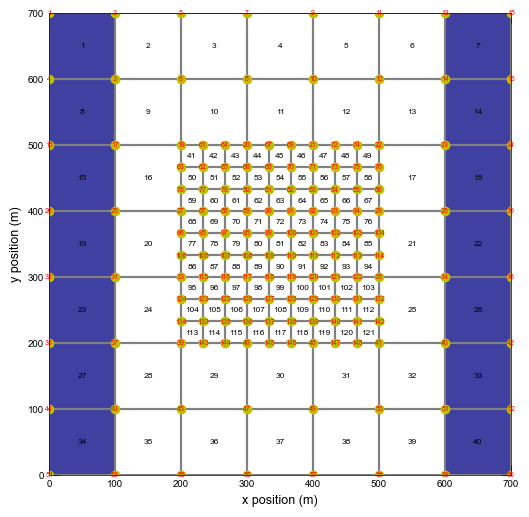

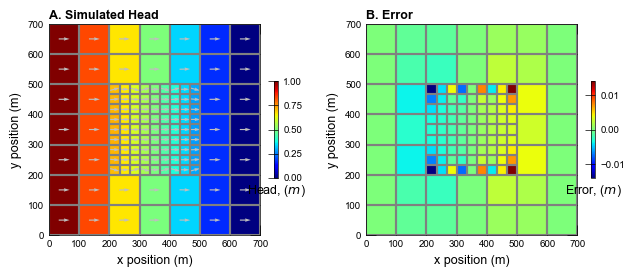

In [6]:
simulation(0)

Run the USG1DISV model with XT3D, then plot heads.

run_models took 19.76 ms


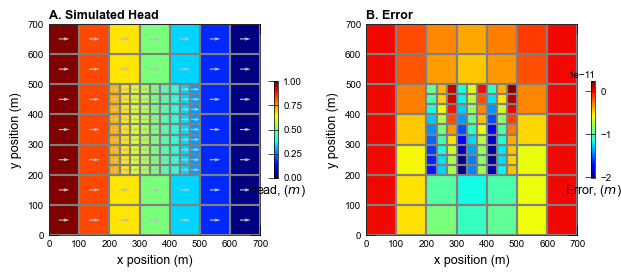

In [7]:
simulation(1)